# EMO task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [2]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-06 21:09:58--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19809 (19K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  19.34K  --.-KB/s    in 0s      

2023-07-06 21:09:58 (65.9 MB/s) - ‘utils.py’ saved [19809/19809]

--2023-07-06 21:09:58--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [11]:
import json
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import BertPreTrainedModel, BertModel
from transformers import RobertaModel,RobertaPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
import importlib
import sys
from torch.utils.data import Dataset
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [5]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Dataset

Dataset paths

In [6]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

Read dataframes

In [7]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

Optional subsample

In [ ]:
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]

Encode targets

In [9]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [10]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

In [13]:
!pip install NRCLex -q #TODO: mettere su
!pip install textblob -q
!python -m textblob.download_corpora -q

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for NRCLex: filename=NRCLex-3.0.0-py3-none-any.whl size=43308 sha256=d8dd80ab9c8428ee28d1b481f66a87f41672bc55bde2093efbc11d14459a5b2c
  Stored in directory: /root/.cache/pip/wheels/d2/10/44/6abfb1234298806a145fd6bcaec8cbc712e88dd1cd6cb242fa
Successfully built NRCLex
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Download

In [75]:
class EMODataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        targets,
        max_len=None
        ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.essay = essay
        self.targets = targets

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])
        inputs = self.tokenizer.encode_plus(
            text=essay,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }
        emos = ['fear','anger','anticipation','trust', 'surprise', 'positive',
                      'negative','sadness', 'disgust', 'joy']
        emotions = NRCLex(essay).raw_emotion_scores
        for emo in emos:
          if emo not in list(emotions.keys()):
            emotions[emo] = 0.0

        keys = list(emotions.keys())
        keys.sort()
        sorted_emotions = {i: emotions[i] for i in keys}
        emotions = list(sorted_emotions.values())
        #print(emotions)
        item['extra_data'] = emotions

        if self.targets is not None:
            item['labels'] = torch.FloatTensor(self.targets[index])
        return item


## Model

In [15]:
model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'bert-base':'bert-base-cased',
  'roberta-base' : 'roberta-base'
}

In [16]:
NUM_LABELS = 8

model_config = {
    'model_id': 'roberta_lexicon',
    'tokenizer_name': model_type.get('roberta-base'),
    'model_name': model_type.get('roberta-base'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0
} # TODO: expand...

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

**Custom "lexicon" model**

In [24]:
from nrclex import NRCLex

In [18]:
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple

class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, extra_data), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [19]:
model = CustomSequenceClassification.from_pretrained("roberta-base", num_labels=NUM_LABELS, num_extra_dims=10)

Some weights of the model checkpoint at roberta-base were not used when initializing CustomSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing CustomSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'roberta.pooler.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.weight', 'roberta.pooler.dense.b

## Training

Prepare datasets

In [76]:
train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)

Set up training

In [28]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 300,
    save_steps = 300,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [77]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [ ]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))

trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [78]:
trainer.train()

Step,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
300,0.295700,0.279857,0.456790,0.713834,0.398190,0.771930,0.451282,0.569579,0.311680,0.186863,0.215001
600,0.190800,0.278330,0.500000,0.747300,0.443966,0.735714,0.528205,0.614925,0.342136,0.255924,0.265309
900,0.122500,0.319195,0.500000,0.762656,0.449799,0.674699,0.574359,0.620499,0.428662,0.301466,0.315518
1200,0.083400,0.326190,0.524691,0.799462,0.510121,0.707865,0.646154,0.675603,0.537201,0.453231,0.477054
1500,0.051600,0.339002,0.524691,0.795536,0.500000,0.694444,0.641026,0.666667,0.501798,0.442386,0.464059


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=1550, training_loss=0.1354884446051813, metrics={'train_runtime': 689.1506, 'train_samples_per_second': 8.953, 'train_steps_per_second': 2.249, 'total_flos': 1634971627376640.0, 'train_loss': 0.1354884446051813, 'epoch': 10.0})

In [ ]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
train_epochs = [log.get('epoch') for log in train_logs if log.get('loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_logs

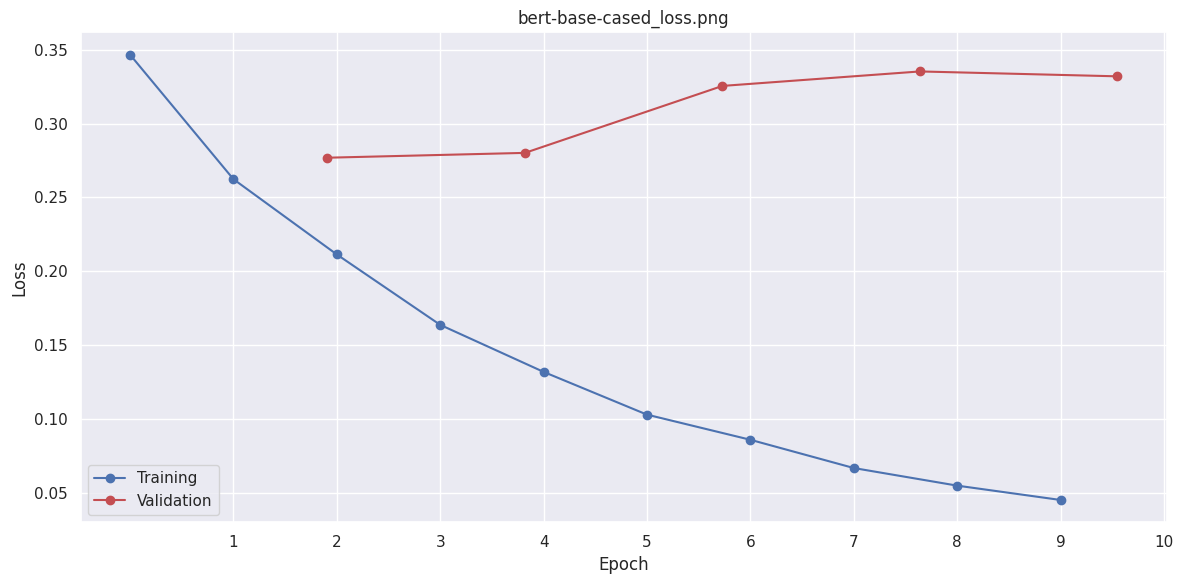

In [ ]:
plot_loss_curve(train_loss_values, eval_loss_values, loss_epochs, eval_epochs,"loss", f"{model_config['model_name']}_loss.png")

## Evaluation

In [79]:
def predict_emotions(results, gold_emotions):

  binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)

  for i, bin_pred in enumerate(binarized_predictions):
    if np.all(bin_pred==0):
      binarized_predictions[i][np.argmax(results.predictions[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [80]:
trainer.state.best_model_checkpoint

'./roberta-base/checkpoint-600'

In [81]:
outs = trainer.predict(dev_set)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
gold_emotions = gold_emotions = label_encoder.decode(outs.label_ids)
predicted_emotions = predict_emotions(outs, gold_emotions)

In [83]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.6341,
 'micro_precision': 0.7464,
 'micro_f': 0.6857,
 'macro_recall': 0.3232,
 'macro_precision': 0.4677,
 'macro_F': 0.3486,
 'accuracy': 0.5217}

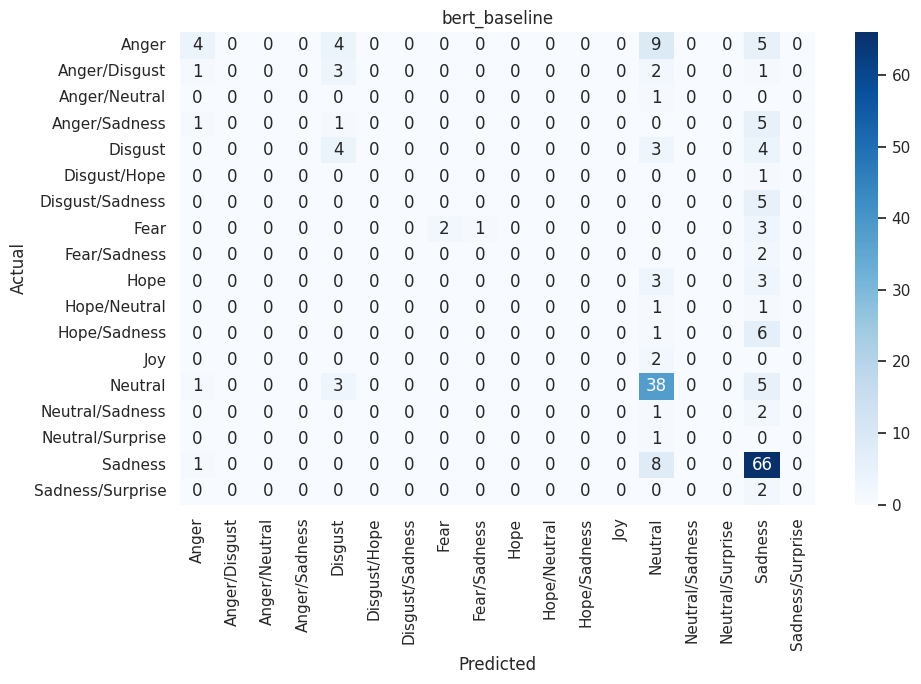

In [ ]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /content/utils.py:40 in plot_model_graph                                                         │
│                                                                                                  │
│    37 │   :param input_data: input data to the model                                             │
│    38 │   :param path: path where to save the graph (no need to specify the extension)           │
│    39 │   '''                                                                                    │
│ ❱  40 │   model_graph = draw_graph(model, input_data=input_data)                                 │
│    41 │   model_graph.visual_graph.render(filename=path)                                         │
│    42 │   model_graph.visual_graph.view()                                                        │
│    43                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'draw_graph' is not defined

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-1980'

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

load checkpoint

In [89]:
# Load the checkpoint file
checkpoint_file = "/content/roberta-base/checkpoint-1200"
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
model = CustomSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS, num_extra_dims = 10)
trainer = Trainer(model=model)
# Perform prediction using the loaded checkpoint
predictions = trainer.predict(dev_set)

In [90]:
gold_emotions = label_encoder.decode(predictions.label_ids)
predicted_emotions = predict_emotions(predictions, gold_emotions)

In [91]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.6504,
 'micro_precision': 0.7407,
 'micro_f': 0.6926,
 'macro_recall': 0.3772,
 'macro_precision': 0.4272,
 'macro_F': 0.3945,
 'accuracy': 0.5298}